# はじめに

国土交通省・JARTICが収集・提供しているオープンデータ「交通量データ」の「交通量API」を分析する簡単なコード例です．せっかくオープンデータとして公開していただいているので，本コードもオープンに公開します．

参考URL：[国交省xROAD](https://www.xroad.mlit.go.jp/), [JARTIC交通量データの提供ページ](https://www.jartic-open-traffic.org/)



# Jupyter notebookのコマンド

In [1]:
%matplotlib inline

In [2]:
from matplotlib.pyplot import *
from numpy import *
from numpy.linalg import *

from tqdm.notebook import tqdm as tqdm
import pandas as pd

rcParams['font.family'] = "MS Gothic"

# APIでデータ取得

In [3]:
import requests
import json
from datetime import datetime

#道路種別を指定．この例は一般道
road_type = "3"

#日時を指定
time_code_from = "20250512"+"0000"
time_code_to   = "20250512"+"2355"

#緯度経度を指定．この例は東京
min_x = 139.45
min_y = 35.55
max_x = 139.93
max_y = 35.82

api = f"https://api.jartic-open-traffic.org/geoserver?service=WFS&version=2.0.0&request=GetFeature&typeNames=t_travospublic_measure_5m&srsName=EPSG:4326&outputFormat=application/json&exceptions=application/json&cql_filter=道路種別={road_type} AND 時間コード>={time_code_from} AND 時間コード<={time_code_to} AND BBOX(ジオメトリ,{min_x},{min_y},{max_x},{max_y},'EPSG:4326')"
response = requests.get(api)

print(response.text[:200])

data = json.loads(response.text)



{"type": "FeatureCollection", "features": [{"type": "Feature", "id": "t_travospublic_measure_5m.24158256.202505121150", "geometry": {"type": "MultiPoint", "coordinates": [[139.7049058, 35.58550262]]},


# 内容確認

In [4]:
time_code_from_obj = datetime.strptime(time_code_from, "%Y%m%d%H%M")
time_code_to_obj = datetime.strptime(time_code_to, "%Y%m%d%H%M")
timestep_counts = ((time_code_to_obj - time_code_from_obj).total_seconds()) // (60*5)

print(f'total: {len(data["features"])}, time counts (aprx): {timestep_counts}, locations (aprx):, {len(data["features"])/timestep_counts}')

total: 5742, time counts (aprx): 287.0, locations (aprx):, 20.006968641114984


In [5]:
data.keys()

dict_keys(['type', 'features', 'totalFeatures', 'numberMatched', 'numberReturned', 'timeStamp', 'crs'])

In [6]:
data["features"][0]

{'type': 'Feature',
 'id': 't_travospublic_measure_5m.24158256.202505121150',
 'geometry': {'type': 'MultiPoint',
  'coordinates': [[139.7049058, 35.58550262]]},
 'geometry_name': 'ジオメトリ',
 'properties': {'地方整備局等番号': 83,
  '開発建設部／都道府県コード': '',
  '常時観測点コード': 3110010,
  '収集時間フラグ（5分間／1時間）': '1',
  '観測年月日': 20250512,
  '時間帯': 1150,
  '上り・小型交通量': 91,
  '上り・大型交通量': 7,
  '上り・車種判別不能交通量': 0,
  '上り・停電': '0',
  '上り・ループ異常': '0',
  '上り・超音波異常': '0',
  '上り・欠測': '0',
  '下り・小型交通量': 73,
  '下り・大型交通量': 10,
  '下り・車種判別不能交通量': 3,
  '下り・停電': '0',
  '下り・ループ異常': '0',
  '下り・超音波異常': '0',
  '下り・欠測': '0',
  '道路種別': '3',
  '時間コード': 202505121150}}

# GeoPandasに変換

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Initialize an empty list to collect rows
rows = []

for feature in data["features"]:
    prop = feature["properties"]
    coords = feature["geometry"]["coordinates"][0]
    
    datetime_obj = datetime.strptime(str(prop['観測年月日'])+str(prop['時間帯']), "%Y%m%d%H%M")

    # Calculate totals
    traffic_up = prop['上り・小型交通量'] + prop['上り・大型交通量'] + prop['上り・車種判別不能交通量']
    traffic_down = prop['下り・小型交通量'] + prop['下り・大型交通量'] + prop['下り・車種判別不能交通量']
    
    rows.append({
        "lon": coords[0],
        "lat": coords[1],
        "datetime": datetime_obj,
        "traffic_up": traffic_up,
        "traffic_down": traffic_down,
        "traffic_up_small": prop['上り・小型交通量'],
        "traffic_up_large": prop['上り・大型交通量'],
        "traffic_up_unidentified": prop['上り・車種判別不能交通量'],
        "traffic_down_small": prop['下り・小型交通量'],
        "traffic_down_large": prop['下り・大型交通量'],
        "traffic_down_unidentified": prop['下り・車種判別不能交通量'],
        "geometry": Point(coords[0], coords[1])
    })

# Create GeoDataFrame in one operation
df = gpd.GeoDataFrame(rows, crs="EPSG:4326")

print(f"Created GeoDataFrame with {len(df)} rows")
df

Created GeoDataFrame with 5742 rows


,lon,lat,datetime,traffic_up,traffic_down,traffic_up_small,traffic_up_large,traffic_up_unidentified,traffic_down_small,traffic_down_large,traffic_down_unidentified,geometry
0,139.704906,35.585503,2025-05-12 11:50:00,98,86,91,7,0,73,10,3,POINT (139.70491 35.5855)
1,139.878654,35.702749,2025-05-12 11:50:00,88,94,71,11,6,74,15,5,POINT (139.87865 35.70275)
2,139.727326,35.564747,2025-05-12 11:50:00,85,77,58,22,5,54,20,3,POINT (139.72733 35.56475)
3,139.685433,35.792401,2025-05-12 11:50:00,51,79,33,16,2,63,16,0,POINT (139.68543 35.7924)
4,139.648182,35.803057,2025-05-12 11:50:00,126,143,83,43,0,91,52,0,POINT (139.64818 35.80306)
...,...,...,...,...,...,...,...,...,...,...,...,...
5737,139.613062,35.607644,2025-05-12 11:10:00,155,136,118,32,5,103,28,5,POINT (139.61306 35.60764)
5738,139.696999,35.748881,2025-05-12 11:10:00,92,78,75,13,4,50,15,13,POINT (139.697 35.74888)
5739,139.683590,35.757753,2025-05-12 11:10:00,118,112,95,20,3,86,22,4,POINT (139.68359 35.75775)
5740,139.900546,35.648160,2025-05-12 11:10:00,117,131,53,54,10,47,73,11,POINT (139.90055 35.64816)


In [8]:
df.to_csv('traffic_data.csv', index=False)
print(f"Data saved to traffic_data.csv with {len(df)} rows and {len(df.columns)} columns")

Data saved to traffic_data.csv with 5742 rows and 12 columns


# 適当に可視化


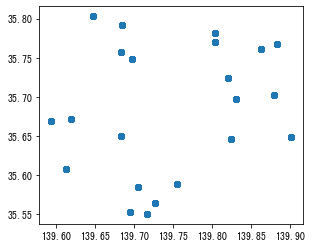

In [9]:
# ただの位置確認

figure()
subplot(111, aspect="equal")
plot(df["lon"], df["lat"], "o")

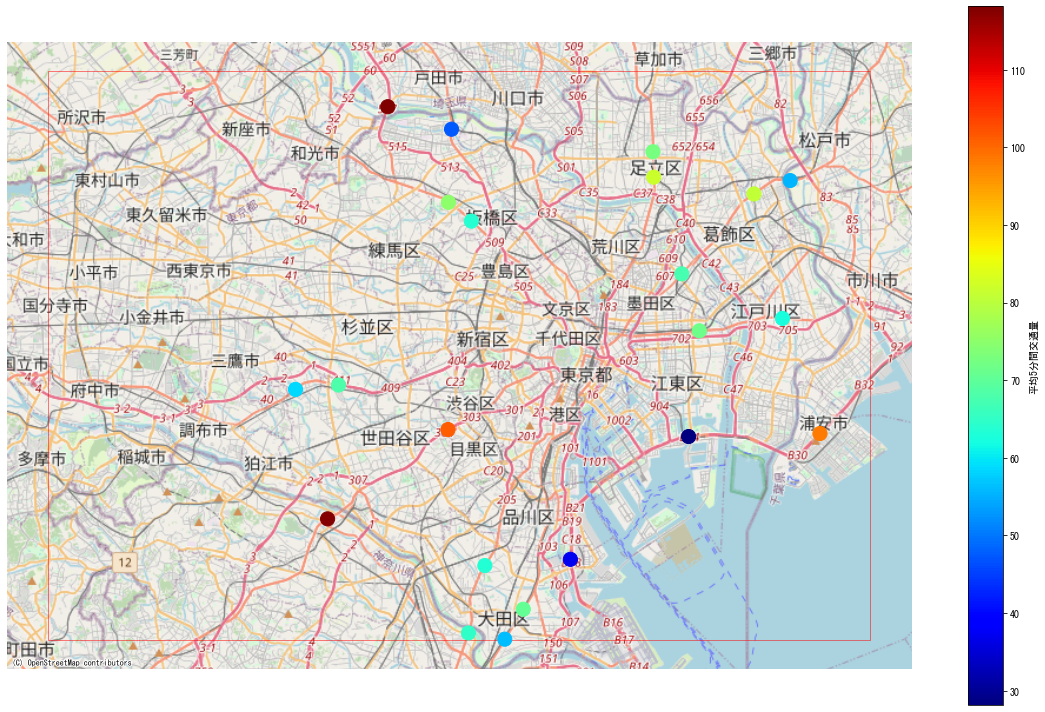

In [ ]:
# OSMと合わせて平均交通量

import contextily as ctx
import geopandas as gpd
from shapely.geometry import box
from pyproj import Transformer

# 緯度経度のbboxを指定
min_lon, min_lat, max_lon, max_lat = min_x, min_y, max_x, max_y 

# bboxからジオメトリを作成
bbox_geom = box(min_lon, min_lat, max_lon, max_lat)

# GeoDataFrameに変換（WGS84座標系）
gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs="EPSG:4326")

# Web Mercator座標系に変換（OSMタイルと合わせるため）
gdf = gdf.to_crs(epsg=3857)

# 交通データ
key = "traffic_up"
df_mean = df.groupby(["lon", "lat"], as_index=False)[key].mean()
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
df_mean["x"], df_mean["y"] = transformer.transform(df_mean["lon"].values, df_mean["lat"].values)

# プロット
fig, ax = subplots(figsize=(16, 10))
gdf.plot(ax=ax, alpha=0.5, edgecolor='red', facecolor='none')

traffic_scat = ax.scatter(df_mean["x"], df_mean["y"], s=200, c=df_mean[key], cmap="jet")

# カラーバーを追加
cbar = fig.colorbar(traffic_scat, ax=ax)
cbar.set_label('平均5分間交通量')

# contextily でOSMタイルを追加
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# 軸ラベルなどを設定
ax.set_axis_off()
tight_layout()
show()

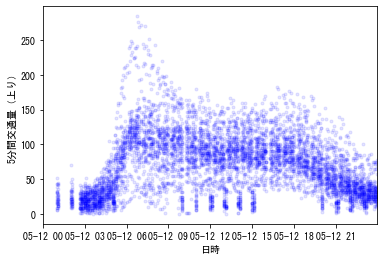

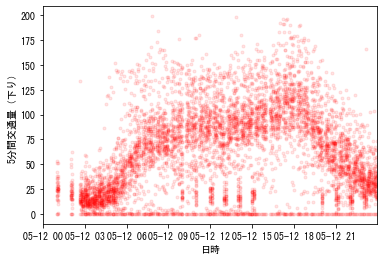

In [11]:
# 時系列プロット

figure()
plot(df["datetime"], df["traffic_up"], "b.", alpha=0.1)
xlim([time_code_from_obj, time_code_to_obj])
ylabel("5分間交通量（上り）")
xlabel("日時")
figure()
plot(df["datetime"], df["traffic_down"], "r.", alpha=0.1)
xlim([time_code_from_obj, time_code_to_obj])
ylabel("5分間交通量（下り）")
xlabel("日時")
show()

↑上りと下りで明らかにパターンが違うのがおもしろい

In [12]:
#下の3次元プロットをインタラクティブに動かす場合
#%matplotlib qt

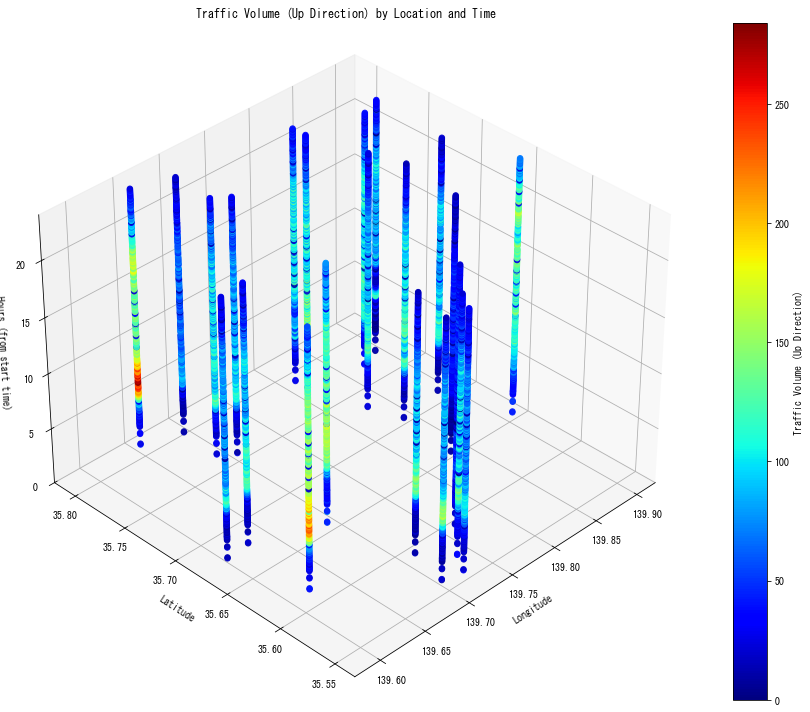

In [13]:
# 3次元時空間プロット

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Create a 3D figure
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Convert datetime to hours from midnight for better visualization
hours = [(dt - time_code_from_obj).total_seconds()/3600 for dt in df['datetime']]

# Create the scatter plot
scatter = ax.scatter(df['lon'], df['lat'], hours, 
                    c=df['traffic_up'], 
                    cmap='jet', 
                    s=30)

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Hours (from start time)')
ax.set_title('Traffic Volume (Up Direction) by Location and Time')

ax.set_zlim([0, (time_code_to_obj-time_code_from_obj).total_seconds()/3600])

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Traffic Volume (Up Direction)')

# Adjust the view angle for better visualization
ax.view_init(elev=35, azim=225)

plt.tight_layout()
plt.show()

# データ出典・ライセンス

データの出典は以下です：交通量 API（国土交通省）機能による交通量(参考値)および国土交通省 API 機能による交通量(参考値)を加工して作成．交通量 API 機能を使用していますが、内容は国土交通省によって保証されたものではありません。

本コードのライセンスはパブリックドメイン（CC0）です．